In [1]:
import torch
from torchvision import datasets, transforms
import os
from torch.utils.data import DataLoader
import numpy as np 
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pickle as pkl

In [2]:
train_on_gpu = torch.cuda.is_available()


if train_on_gpu:
    print("Your are using GPU")
else:
    print("You are using CPU")


Your are using GPU


In [32]:
#Lets create a dataloader

root_dir = "../input/tagged-anime-illustrations/danbooru-images/danbooru-images/"

def create_dataloader(root_dir, batch_size, shuffle = True):
    #Let us define transforms
    transform = transforms.Compose([transforms.Resize(64),
                                    transforms.ToTensor()])
    
    #Let's define a dataset
    dataset = datasets.ImageFolder(root_dir, transform = transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)
    
    return dataloader
    

In [33]:
image_loader = create_dataloader(root_dir, batch_size = 20)

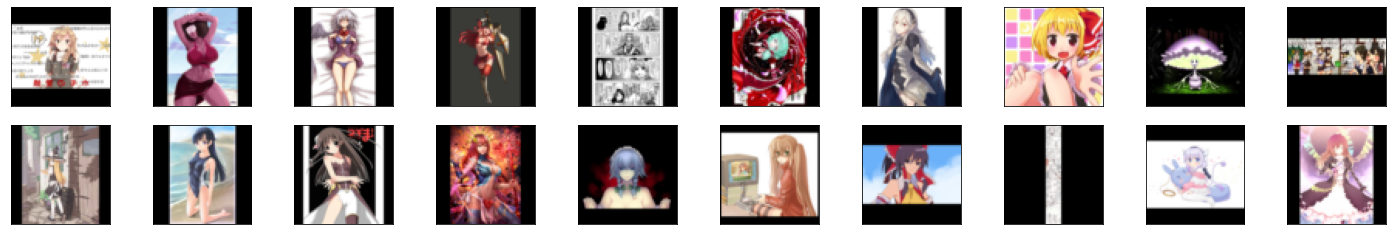

In [34]:
image_iter = iter(image_loader)
images, _ = image_iter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    


In [6]:
#Lets check where our range of pixels are

for image in range(10):
    print("This is our minimun pixel: ", str(images[image].min()), "for image number", str(image))
    print("This is our maximun pixel: ", str(images[image].max()), "for image number", str(image))

This is our minimun pixel:  0.0 for image number 0
This is our maximun pixel:  1.0 for image number 0
This is our minimun pixel:  0.0 for image number 1
This is our maximun pixel:  1.0 for image number 1
This is our minimun pixel:  0.0 for image number 2
This is our maximun pixel:  1.0 for image number 2
This is our minimun pixel:  0.0 for image number 3
This is our maximun pixel:  1.0 for image number 3
This is our minimun pixel:  0.0 for image number 4
This is our maximun pixel:  1.0 for image number 4
This is our minimun pixel:  0.0 for image number 5
This is our maximun pixel:  1.0 for image number 5
This is our minimun pixel:  0.0 for image number 6
This is our maximun pixel:  1.0 for image number 6
This is our minimun pixel:  0.0 for image number 7
This is our maximun pixel:  1.0 for image number 7
This is our minimun pixel:  0.0 for image number 8
This is our maximun pixel:  1.0 for image number 8
This is our minimun pixel:  0.0 for image number 9
This is our maximun pixel:  0.9

### We need to scale our data so that it looks like it has a tanh output. Both the generator and the real image will have images that have pixels [-1, 1]

In [7]:
def scale(image):
    
    #min_features = image.min() close to 0
    #max_features = image.max() close to 1
    
    image = image * 2 # (0, 1) --> (0, 2)
    image = image - 1 #(0, 2) --> (-1, 1)
    
    return image
    
    

In [8]:
scaled_image = scale(images[0])

print(scaled_image.min())
print(scaled_image.max())

regular_image = images[0]

print(regular_image.min())
print(regular_image.max())


-1.0
1.0
0.0
1.0


## Let us now define the discriminator

#### Let us import the right frameworks

In [9]:
import torch.nn as nn

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = nn.Conv2d(3, conv_dim, 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim * 2, 4, stride = 2, padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(conv_dim * 2)
        self.conv3 = nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, stride = 2, padding = 1)
        self.batchnorm3 = nn.BatchNorm2d(conv_dim * 4)
        self.conv4 = nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, stride = 2, padding = 1)
        self.batchnorm4 = nn.BatchNorm2d(conv_dim * 8)
        
        self.fc1 = nn.Linear(conv_dim * 8 * 4, 1)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.2)
        
        
    def forward(self, x):
        
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.batchnorm2(self.conv2(x)))
        x = self.leaky_relu(self.batchnorm3(self.conv3(x)))
        x = self.leaky_relu(self.batchnorm4(self.conv4(x)))
        
        x = x.view(-1, self.conv_dim * 8 * 4)
        x = self.fc1(x)
        
        return x

### Now we are going to define the generator

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        
        # It is going to take in a z size and shape it into a tanh image
        # Make sure to look at the research paper
        
        self.z_size = z_size
        self.conv_dim = conv_dim
        
        self.reshaper = nn.Linear(z_size, conv_dim * 8 * 4 * 4)
        
        #In paper conv_dim = 128 
        # (4, 4, 1024)
        self.deconv1 = nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, kernel_size = 4, stride = 2, padding = 1) # (8, 8, 512)
        self.batchnorm1 = nn.BatchNorm2d(conv_dim * 4)
        self.deconv2 = nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, kernel_size = 4, stride = 2, padding = 1) # (16, 16, 256)
        self.batchnorm2 = nn.BatchNorm2d(conv_dim * 2)
        self.deconv3 = nn.ConvTranspose2d(conv_dim * 2, conv_dim, kernel_size = 4, stride = 2, padding = 1) # (32, 32, 128)
        self.batchnorm3 = nn.BatchNorm2d(conv_dim)
        self.deconv4 = nn.ConvTranspose2d(conv_dim, 3, kernel_size = 4, stride = 2, padding = 1) # (64, 64, 3)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, z):
        
        thick_z = self.reshaper(z)
        layer_block = thick_z.view(-1, self.conv_dim * 8, 4, 4)
        
        out = self.relu(self.batchnorm1(self.deconv1(layer_block)))
        out = self.relu(self.batchnorm2(self.deconv2(out)))
        out = self.relu(self.batchnorm3(self.deconv3(out)))
        out = self.tanh(self.deconv4(out))
        
        return out

### Now we have to define the losses
* Real Loss how far is the output of Discriminator from 1
* Fake Loss how far is the output of the Discriminator from 0

In [12]:
#Lets define real loss

def real_loss(D_out):
    #Lets use mean squared error
    # D_out since batch_size = 20: 
    # [[len = 20], output of 1 node, output of 1 node, etc.]
    
    loss = torch.mean(torch.square(D_out.squeeze() - 1))
    return loss

#Lets define the fake_loss
def fake_loss(D_out):
    
    loss = torch.mean(torch.square(D_out.squeeze()))
    return loss
        

### Now lets include a weight initialization step

In [13]:
def weight_init_normal(m):
    
    classname = m.__class__.__name__
    
    if classname.find("Linear") != -1 or classname.find("Conv") != -1:
        
        sd = 0.02
        mean = 0
        
        m.weight.data.normal_(mean, sd)
        m.bias.data.fill_(0)
    

## Let us build the network

In [14]:
z_size = 100
g_conv_dim = 128
d_conv_dim = 32

G = Generator(z_size, g_conv_dim)
D = Discriminator(d_conv_dim)

In [15]:
G.apply(weight_init_normal)
D.apply(weight_init_normal)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

In [16]:
print(G)
print(D)

Generator(
  (reshaper): Linear(in_features=100, out_features=16384, bias=True)
  (deconv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (tanh): Tanh()
)
Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### Now we are going to define the optimizers and gradients

In [17]:
# Define the optimizer and look up documentation for the beta1 and beta2

learning_rate = 0.001

d_optimizer = optim.Adam(G.parameters(), betas=(0.5, 0.999), lr = learning_rate)
g_optimizer = optim.Adam(D.parameters(), betas=(0.5, 0.999), lr = learning_rate)



In [18]:
def train(Generator, Discriminator, epochs, print_every = 500):
    
    samples = []
    
    if train_on_gpu:
        Generator.cuda()
        Discriminator.cuda()
    
    sample_size = 20
    sample_z = np.random.uniform(low=-1, high=1, size=[sample_size, z_size])
    sample_z = torch.from_numpy(sample_z).float()
    
    if train_on_gpu:
        sample_z = sample_z.cuda()
    
    epoch_number = 0
    for epoch in range(epochs):
        epoch_number += 1
        for batch_i, (image, _) in enumerate(image_loader):
            
            batch_size = image.size(0)
            image = scale(image)
            
            if train_on_gpu:
                image = image.cuda()
                
            # Lets see how well the Discriminator can tell if it is real
            
            d_optimizer.zero_grad()
            D_real = D(image)
            d_real_loss = real_loss(D_real)
            
            #Lets create a fake image
            z = np.random.uniform(low = -1, high = 1, size = [batch_size, z_size])
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            generated_image = G(z)
            
            #How well the discriminator tells if the fake image is 0
            
            D_fake = D(generated_image)
            d_fake_loss = fake_loss(generated_image)
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            g_optimizer.zero_grad()
            z = torch.cuda.FloatTensor(batch_size, z_size).uniform_(-1, 1)
            if train_on_gpu:
                z = z.cuda()
                
            generated_image = G(z)
            G_out = D(generated_image)
            g_loss = real_loss(G_out)
            
            g_loss.backward()
            g_optimizer.step()
            
            if batch_i % print_every == 0:
                print("Epoch: ", str(epoch_number), "Batch Number: ", str(batch_i))
                print("Generator Loss: ", str(g_loss.item()), "Discriminator Loss: ", str(d_loss.item()))
                
                # Lets test the Generator on some samples
                
        G.eval()
        fixed_image = G(sample_z)
        samples.append(fixed_image)
        G.train() 

        # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)       
                

In [19]:
epochs = 1
train(G, D, epochs = epochs)

Epoch:  1 Batch Number:  0
Generator Loss:  1.174137830734253 Discriminator Loss:  1.1964250802993774
Epoch:  1 Batch Number:  500
Generator Loss:  0.0019407414365559816 Discriminator Loss:  0.13816621899604797
Epoch:  1 Batch Number:  1000
Generator Loss:  0.0009289567242376506 Discriminator Loss:  0.12270472943782806
Epoch:  1 Batch Number:  1500
Generator Loss:  1.4296005019787117e-06 Discriminator Loss:  0.02281324379146099
Epoch:  1 Batch Number:  2000
Generator Loss:  1.2374026482575573e-05 Discriminator Loss:  0.0339527390897274
Epoch:  1 Batch Number:  2500
Generator Loss:  0.00020023706019856036 Discriminator Loss:  0.01747433841228485


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:594: UserWarning: Metadata Warning, tag 296 had too many entries: 2, expected 1
  % (tag, len(values))


Epoch:  1 Batch Number:  3000
Generator Loss:  0.002117657568305731 Discriminator Loss:  0.028333283960819244
Epoch:  1 Batch Number:  3500
Generator Loss:  0.003592869732528925 Discriminator Loss:  0.015198183245956898
Epoch:  1 Batch Number:  4000
Generator Loss:  0.0005794932367280126 Discriminator Loss:  0.027862219139933586


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch:  1 Batch Number:  4500
Generator Loss:  4.312570672482252e-05 Discriminator Loss:  0.02338128350675106
Epoch:  1 Batch Number:  5000
Generator Loss:  0.009808267466723919 Discriminator Loss:  0.054529208689928055
Epoch:  1 Batch Number:  5500
Generator Loss:  3.5703996559277584e-07 Discriminator Loss:  0.0659218579530716
Epoch:  1 Batch Number:  6000
Generator Loss:  7.3546798375900835e-06 Discriminator Loss:  0.073124460875988
Epoch:  1 Batch Number:  6500
Generator Loss:  0.000168655053130351 Discriminator Loss:  0.030358068645000458
Epoch:  1 Batch Number:  7000
Generator Loss:  0.0005917163798585534 Discriminator Loss:  0.0559692345559597


KeyboardInterrupt: 